# Importing the libraries

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Impoting the Dataset in the H5PY fromat


In [2]:
f = h5py.File('galaxies.Z00.h5','r')

In [3]:
f.keys()

<KeysViewHDF5 ['Galaxies']>

In [4]:
list( f.keys() )

['Galaxies']

# Using the h5py file using Pandas

In [5]:
df = pd.DataFrame(f['Galaxies'][:])
df=df.iloc[:,0:9]
df=df.iloc[:20000, :]

In [6]:
df.head()

,Halo_mass,Halo_growth_rate,Halo_mass_peak,Scale_peak_mass,Scale_half_mass,Halo_radius,Concentration,Halo_spin,Stellar_mass
0,11.291506,0.000000,11.933064,0.52,0.26,0.153729,207.948105,0.03063,10.426738
1,11.107182,0.000000,11.269677,0.89,0.49,0.133456,119.950928,0.02274,9.099111
2,10.774375,5.415474,11.231920,0.38,0.30,0.103370,20.775208,0.00583,9.304751
3,9.996202,0.150599,10.529177,0.55,0.47,0.056887,39.662548,0.03998,7.168949
4,9.668787,0.000000,10.674248,0.65,0.26,0.044248,46.062977,0.02509,7.502442


# Checking for NaN values in Dataset

In [7]:
df.isna().sum()

Halo_mass           0
Halo_growth_rate    0
Halo_mass_peak      0
Scale_peak_mass     0
Scale_half_mass     0
Halo_radius         0
Concentration       0
Halo_spin           0
Stellar_mass        0
dtype: int64

# Inspecting the Features in the Dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012F230F7B88>,
      dtype=object)

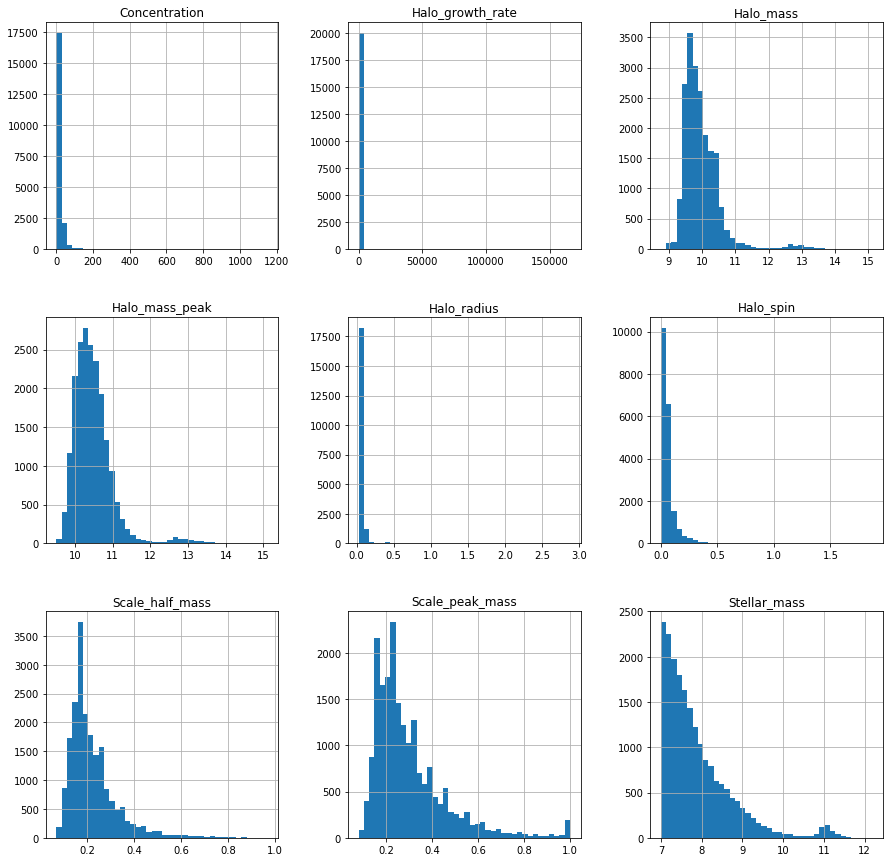

In [8]:
df.hist(bins=40, figsize=[15,15])

# Data Visualization using Correlation Heatmap

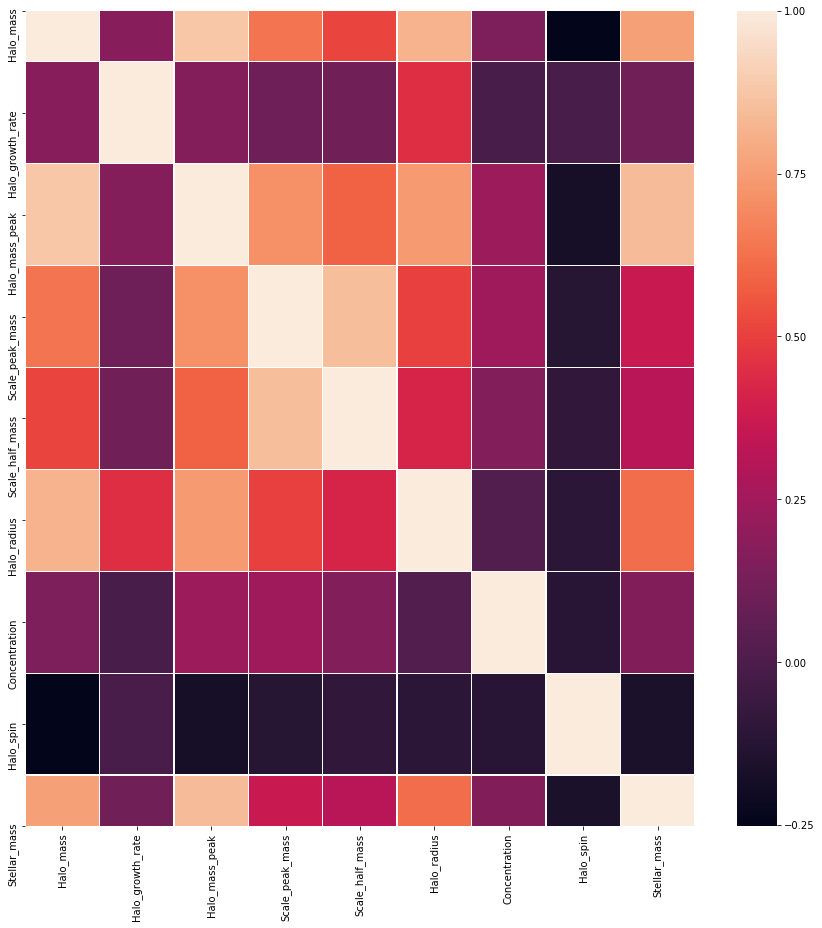

In [9]:
correlationMatrix=df.corr()
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(correlationMatrix, annot=False, linewidths=.5, ax=ax)

In [10]:
correlationMatrix.iloc[:, 8].sort_values()

Halo_spin          -0.159894
Halo_growth_rate    0.108067
Concentration       0.158072
Scale_half_mass     0.316507
Scale_peak_mass     0.367370
Halo_radius         0.614438
Halo_mass           0.758103
Halo_mass_peak      0.848301
Stellar_mass        1.000000
Name: Stellar_mass, dtype: float64

# Preprocessing

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

### Splitting of Labels and Features

In [12]:
df1=df.copy()
X=df1.drop(["Stellar_mass"], axis=1)
y= df1["Stellar_mass"]

###  Splitting data into Training and Testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Feature Scaling

In [14]:
class featureSelection(BaseEstimator, TransformerMixin):
    
    def __init__(self, featureList):
        self.featureList = featureList
    
    def transform(self, X):
        return X[self.featureList].values
    
    def fit(self, X, y=None):
        return self

In [15]:
minmaxFeature=["Concentration", "Halo_growth_rate","Halo_radius", "Halo_spin", "Scale_peak_mass" ]
standardFeature= ["Halo_mass", "Halo_mass_peak", "Scale_half_mass"] 

In [16]:
#Pipeline for minmax Scaling
minmaxStep= [("minmax_selector", featureSelection(minmaxFeature)),
               ("simpleImputer", SimpleImputer(strategy = 'mean')),("minmax_scaler", MinMaxScaler())]
minmaxPipeline= Pipeline(minmaxStep)

In [17]:
#Pipeline for Standard Scaling
standardStep= [("standard_selector", featureSelection(standardFeature)),
               ("simpleImputer", SimpleImputer(strategy = 'mean')),("standard_scaler", StandardScaler())]
standardPipeline= Pipeline(standardStep)

In [18]:
#Pipeline for combined output from the above pipelines
finalPipeline=FeatureUnion([("minmax", minmaxPipeline), ("standard", standardPipeline)])

# Regression using Random Forest, SVM, SGD 

### Cross-Validation

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [20]:
def displayScores(scores):
    print("Scores:", scores)
    print("Mean Score:", scores.mean())
    print("Standard Deviation of Scores:", scores.std())

In [21]:
#Random Forest Regression
RandomForestSteps=[("prep", finalPipeline), ("RandomForest", RandomForestRegressor())]
RFRegress=Pipeline(RandomForestSteps)

CrossValidation_score=cross_val_score(RFRegress, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
displayScores(CrossValidation_score)

Scores: [-0.0479223  -0.04845389 -0.04800252 -0.04946855 -0.04633617]
Mean Score: -0.048036686718779156
Standard Deviation of Scores: 0.0010129436634708695


In [22]:
#Support Vector Regression
SupportVectorSteps=[("prep", finalPipeline), ("SupportVector", SVR())]
SupportVectorRegressor=Pipeline(SupportVectorSteps)

CrossValidation_score=cross_val_score(SupportVectorRegressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
displayScores(CrossValidation_score)

Scores: [-0.05938094 -0.06165391 -0.06029985 -0.06255993 -0.05551541]
Mean Score: -0.059882005857068
Standard Deviation of Scores: 0.002441462311818337


In [23]:
#Stochastic Gradient Descent Regression
StochasticGradientDescentSteps=[("prep", finalPipeline), ("StochasticGradient", SGDRegressor())]
StochasticGradientDescentRegressor=Pipeline(StochasticGradientDescentSteps)

CrossValidation_score=cross_val_score(StochasticGradientDescentRegressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
displayScores(CrossValidation_score)

Scores: [-0.12334731 -0.13818001 -0.13081178 -0.13408314 -0.13001809]
Mean Score: -0.13128806501516227
Standard Deviation of Scores: 0.004903195877470768


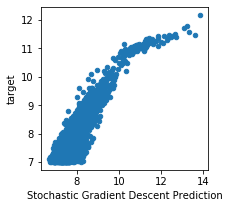

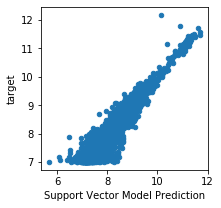

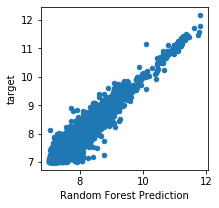

In [24]:
RFRegress.fit(X_train, y_train)
SupportVectorRegressor.fit(X_train, y_train)
StochasticGradientDescentRegressor.fit(X_train, y_train)

result = pd.DataFrame({ "target": y_test, "Random Forest Prediction":RFRegress.predict(X_test), 
                      "Support Vector Model Prediction": SupportVectorRegressor.predict(X_test), 
                      "Stochastic Gradient Descent Prediction": StochasticGradientDescentRegressor.predict(X_test)})

result.plot.scatter(x="Stochastic Gradient Descent Prediction", 
                         y = "target", figsize=[3,3])
result.plot.scatter(x="Support Vector Model Prediction", 
                y = "target", figsize=[3,3])
result.plot.scatter(x="Random Forest Prediction", 
                        y = "target", figsize=[3,3])

### Hyperparameter Search using GridSearch

In [25]:
from sklearn.model_selection import GridSearchCV
ff = [{"RandomForest__max_depth": range(1,30)}]
GSCrossValidation=GridSearchCV(RFRegress, ff, scoring = 'neg_mean_absolute_error')
GSCrossValidation.fit(X_train, y_train)
print(f"Best Max_dept : {GSCrossValidation.best_params_}")

Best Max_dept : {'RandomForest__max_depth': 12}


In [26]:
X_prep=finalPipeline.fit_transform(X_train, y_train)

### Evaluation 


In [27]:
RandomForestSteps=[("prep", finalPipeline), ("RF", RandomForestRegressor(max_depth=12))]
RandomForestRegressor_12=Pipeline(RandomForestSteps)
RandomForestRegressor_12.fit(X_train, y_train)
results_RF= pd.DataFrame({ "target": y_test, "RF Prediction":RFRegress.predict(X_test)})
results_RF.head()


,target,RF Prediction
19134,7.238688,7.431878
4981,7.735857,7.747886
16643,7.497379,7.399315
19117,7.328487,7.236345
5306,7.121845,7.116305


# Regression with Neural Network

In [29]:
from sklearn.neural_network import MLPRegressor

MLPSteps=[("prep", finalPipeline), ("MLP", MLPRegressor(hidden_layer_sizes=(6,5,)))]
MLPRegress=Pipeline(MLPSteps)
CrossValidation_MLP_score=cross_val_score(MLPRegress, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
displayScores(CrossValidation_MLP_score)


Scores: [-0.07643345 -0.05915591 -0.08679418 -0.05692075 -0.0515874 ]
Mean Score: -0.06617833903482959
Standard Deviation of Scores: 0.013252119787218875


In [30]:
pg_MLP= [{"MLP__hidden_layer_sizes": [(6, 5,), (6, 4,), (6,3,),(6,2,), (5,4,),(5,3,), (5,2,), (4,6,)]  } ]

GSCV_MLP=GridSearchCV(MLPRegress, pg_MLP, scoring = 'neg_mean_absolute_error')
GSCV_MLP.fit(X_train, y_train)
print(f"Best Max_dept : {GSCV_MLP.best_params_}")

Best Max_dept : {'MLP__hidden_layer_sizes': (6, 2)}


# Feature Selection and Dimensionality Reduction

### Feature Selection using Random Forest  

In [31]:
randomForest=RandomForestRegressor(max_depth=13)
randomForest.fit(X_prep, y_train)
featureImportanceScore = pd.DataFrame({"Features": np.array(X.columns), "Importance Score": np.array(randomForest.feature_importances_) })
featureImportanceScore

,Features,Importance Score
0,Halo_mass,0.008448
1,Halo_growth_rate,0.000162
2,Halo_mass_peak,0.012299
3,Scale_peak_mass,0.007223
4,Scale_half_mass,0.119790
5,Halo_radius,0.006359
6,Concentration,0.824339
7,Halo_spin,0.021380


In [32]:
importantFeature=["Concentration", "Scale_half_mass"]
X_featureImportance=X[importantFeature]
X_featureImportance_train, X_featureImportance_test, y_train, y_test=train_test_split(X_featureImportance, y, test_size=0.2)

In [33]:
minmaxFeature_importantFeature=["Concentration"]
standardFeature_importantFeature= ["Scale_half_mass"] 

In [34]:
minmaxStep_importantFeature= [("minmax_selector", featureSelection(minmaxFeature_importantFeature)),
               ("simpleImputer", SimpleImputer(strategy = 'mean')),("minmax_scaler", MinMaxScaler())]
minmaxPipeline_importantFeature= Pipeline(minmaxStep_importantFeature)

In [35]:
standardStep_importantFeature= [("standard_selector", featureSelection(standardFeature_importantFeature)),
               ("simpleImputer", SimpleImputer(strategy = 'mean')),("standard_scaler", StandardScaler())]
standardPipeline_importantFeature= Pipeline(standardStep_importantFeature)

In [36]:
finalPipeline_importantFeature=FeatureUnion([("minmax", minmaxPipeline_importantFeature), ("standard", standardPipeline_importantFeature)])

In [37]:
RandomForestSteps_importantFeature=[("finalPipeline", finalPipeline_importantFeature), ("RandomForest", RandomForestRegressor())]
RandomForest_regressor_importantFeature=Pipeline(RandomForestSteps_importantFeature)

In [39]:
CrossValidationScore_importantFeature=cross_val_score(RandomForest_regressor_importantFeature, X_featureImportance, y, cv=5, scoring="neg_mean_squared_error")
displayScores(CrossValidationScore_importantFeature)

Scores: [-0.76961874 -0.71160877 -0.73913685 -0.89901821 -1.1746662 ]
Mean Score: -0.8588097537753008
Standard Deviation of Scores: 0.17048564805929345


### PCA

In [40]:
from sklearn.decomposition import PCA

In [41]:
PCAStep=[("PCAprep_pipe",FeatureUnion([("minmax", minmaxPipeline), ("standard", standardPipeline)])),
                    ("pca", PCA(n_components=2))]
pcaPipeline=Pipeline(PCAStep)
X_PCA=pcaPipeline.fit_transform(X)

In [42]:
#Pipeline for Random Forest Regression with PCA
PCARFStep=[("PCARF_pipe",FeatureUnion([("minmax", minmaxPipeline), ("standard", standardPipeline)])),
                    ("pca", PCA(n_components=2)),("RF", RandomForestRegressor()) ]
RFRegressor_PCAPipeline=Pipeline(PCARFStep)

In [43]:
CrossValidationScore_PCA=cross_val_score(RFRegressor_PCAPipeline, X, y, cv=5, scoring="neg_mean_squared_error")
displayScores(CrossValidationScore_PCA)

Scores: [-0.22485759 -0.20578436 -0.2122099  -0.17498289 -0.35915835]
Mean Score: -0.23539861824087732
Standard Deviation of Scores: 0.06401932045437951
